# Computational Biology Coursework / Panagiotis Sotirellos / u2084078





In [1]:
#import relevant libraries

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np. set_printoptions(threshold=np. inf)
from sklearn.metrics import confusion_matrix, accuracy_score
from numpy import mean
from numpy.random import randint
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from numpy import mean
from numpy.random import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV


 


# Question 1

**i)** How many training and test examples are there? You can use np.loadtxt for this purpose.
Show at least 10 randomly selected objects of each class using plt.matshow. 

In [2]:
#read train,test and label data and show their lengths

x_train = np.loadtxt('Xtrain.csv')
x_test = np.loadtxt('Xtest.csv')
y_labels = np.loadtxt('Ytrain.csv')

print('Training examples',len(x_train))
print('Test examples',len(x_test))
print('Labels',len(y_labels))




Training examples 3000
Test examples 3000
Labels 3000


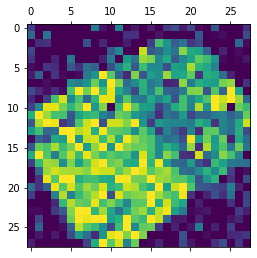

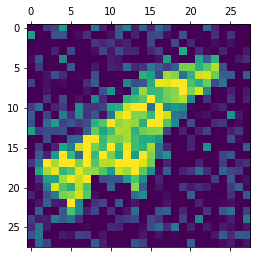

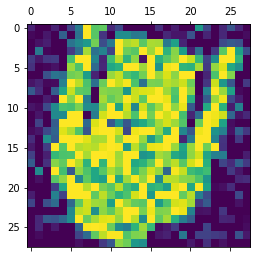

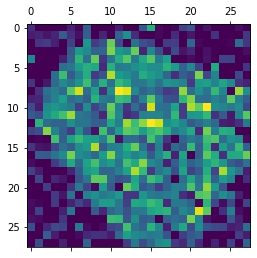

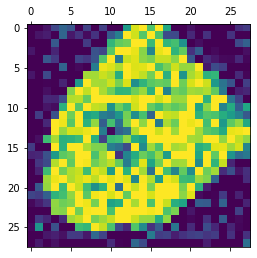

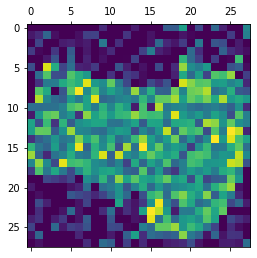

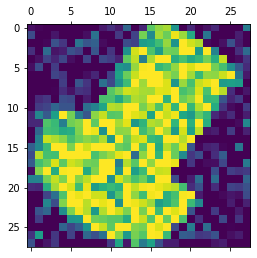

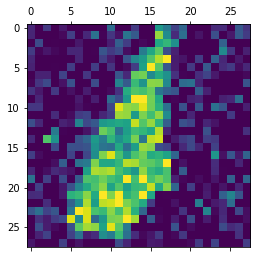

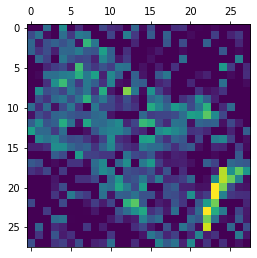

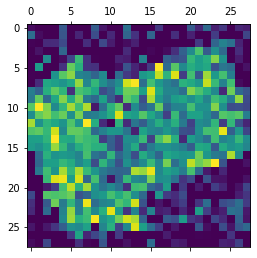

In [3]:
#Show 10 random elements that have a negative label class using matshow
var_neg = np.where(y_labels == -1)[0]


neg_random = np.random.choice(var_neg, size = 10) 

for i in neg_random:
    plt.matshow(x_train[i].reshape(28,28))

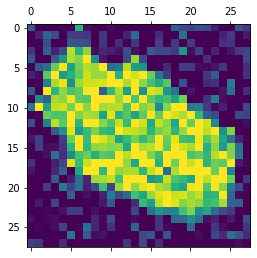

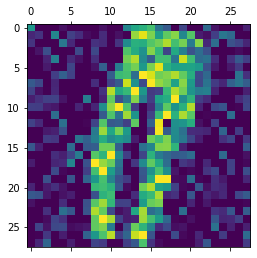

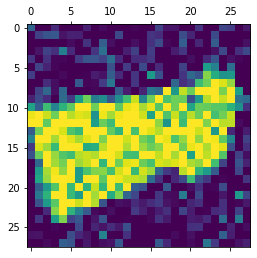

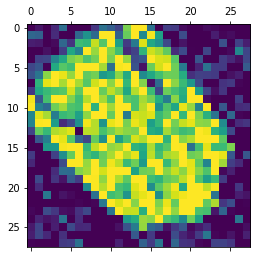

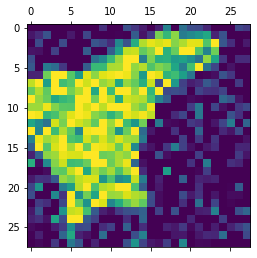

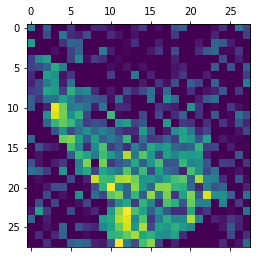

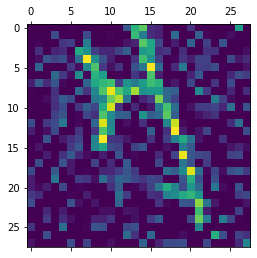

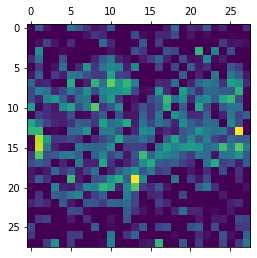

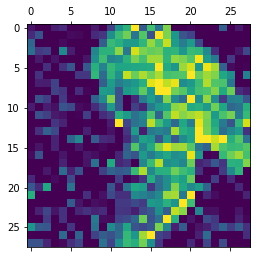

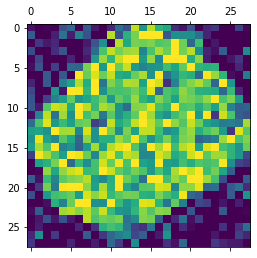

In [4]:
#Show 10 random elements that have a positive label class using matshow

var_pos = np.where(y_labels == 1)[0]

pos_random = np.random.choice(var_pos, size = 10)

for i in pos_random:
    plt.matshow(x_train[i].reshape(28,28))

**ii)** How many positive and negative examples are there in the training dataset?

In [5]:
print('Negative examples :',len(np.where(y_labels == -1)[0]))
print('Positive examples : ',len(np.where(y_labels == 1)[0]))

Negative examples : 882
Positive examples :  2118


In [6]:
#Alternative way to do the same:
pos=0
neg=0

for i in y_labels:
    if i>0:
        pos=pos+1
    elif i<0:
        neg=neg+1
print(pos,neg)

2118 882


**iii)** Which performance metric (accuracy, AUC-ROC and AUC-PR) should be used? Give your
reasoning

In [7]:

print("Positive Class distributiom ",pos/3000,'%')
print("Negative Class distribution ",neg/3000,'%')

Positive Class distributiom  0.706 %
Negative Class distribution  0.294 %


The dataset is biased (70/30) split of positive/negative cases so accuracy would not be a great indicator
as it would fail to account for the imbalance of the classes in the results. AUC-PR works better for when we 
care more about the positive class as AUC-PR focuses mainly on the positive class (PPV and TPR) it cares less 
about the frequency of the negative class,so AUC-PR is more sensitive for improvements in the positive class because of its components (we would use it in credit card fraud detection were we care more about the undersampled positive class).However the dataset is biased on the positive class we would not want to use AUC-PR. This means that **AUC-ROC** is the best metric for somewhat imbalanced datasets like the one we have


**iv)** What is the expected accuracy of a random classifier (one that generates random labels for a given example) for this problem over the training and test datasets? Demonstrate why this would be the case.




We expect the accuracy of a random classifier to be  aproximately **50%** thus we make an experiment, we make a random classifier picking a class randomly from y_labels and run it 1000 times since this is a binary classification problem (-1/1) we expect the naive classifier to yield a 50% accuracy. **We get scores only for the test data and if we assume (IID) distributions we can say that the scores will be equivelant for the training data.**

However because it is bad practice (checking accuracy of training data) i will not implement it.

I have constructed 2 approaches for this problem yielding the same results (sorry did it for my understanding)

In [8]:
#Another implementation with an 80 20 split of train and test data
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

#split data 80-20

train_x, test_x, train_y, test_y = train_test_split(x_train, y_labels,test_size=0.2,shuffle=True,random_state=42)

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(train_x, train_y)
dummy_y_pred = dummy_clf.predict(test_x)
dummy_y_proba = dummy_clf.predict_proba(test_x)[:,1]
accuracy_score(test_y,dummy_y_pred, normalize=True)


0.48

**v)** What is the AUC-ROC and AUC-PR of a random classifier for this problem over the training
and test datasets? Demonstrate why this would be the case.

In [9]:
#we can assume that the y_test labels will be identicaly and indipendently distributed (IID) alike the y_labels 
#we have 

#AUC-ROC score for the random classifier we have implemented above
print('AUC-ROC:',metrics.roc_auc_score(test_y,dummy_y_proba))

#AUC-PR score for the random classifier we have implemented above
print('AUC-PR:',metrics.average_precision_score(test_y,dummy_y_proba))

AUC-ROC: 0.5
AUC-PR: 0.735


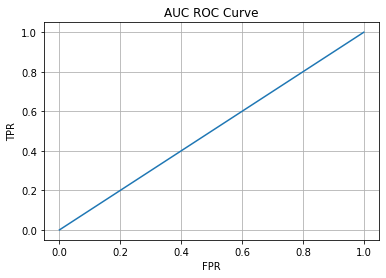

In [10]:
#AUC ROC CURVE

from sklearn.metrics import roc_curve

fpr,tpr,_ = roc_curve(test_y,dummy_y_proba)

plt.title('AUC ROC Curve')
plt.plot(fpr,tpr)

plt.xlabel('FPR')

plt.ylabel('TPR')

plt.grid()


We expect AUC-ROC and AUC-PR of a random classifier to be 0.5 and 0.7 respectively.This is because of their components: namely For ROC we have TPR(recall) and FPR(precision)

**TPR=TP/(TP+FN);FPR=FP/(FP+TN)**

TPR represents the percentage of all those "Samples that should be classified as 1"  and are classified as 1

FPR represents the percentage of all the "Samples that should be classified as 0" and are misclassified as 1;

In this case, if it is a random classifier, the possibility that we get a sample that is classified as 0 or 1 should be the same. ROC is the plot of TPR vs FPR.

Regarding PR: we should have the fraction of the majority class for a naive classifier

In general precision=tp/(tp+fp)=0.5*positive/(0.3*negative+0.7*positive)= fraction of majority class because in our example this is 70 (positive) and 30(negative)

# Question 2


Perform 5-fold stratified cross-validation (https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) over the training
dataset using the k = 1 nearest neighbour classifier

In [11]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


**i)** What is the prediction accuracy, AUC-ROC and AUC-PR for each fold using this classifier? Show code to demonstrate the results

In [12]:
skf= StratifiedKFold(n_splits= 5)

In [13]:
#initialise empty lists to show the scores for the 5 different steps

def knn1(xtrain,ytrain,k):
    
    accuracies_0=[]
    AUC_ROC_0=[]
    AUC_PR_0=[]
    for train_index, test_index in skf.split(xtrain,ytrain):
        train_x, test_x, train_y, test_y = xtrain[train_index], xtrain[test_index],ytrain[train_index],ytrain[test_index]
        #now train and fit the model
        knn=KNeighborsClassifier(n_neighbors = k)
        knn.fit(train_x,train_y)
        #now make a prediction on yhat
        y_pred = knn.predict(test_x) #this is for accuracy
        
        y_scores = knn.predict_proba(test_x)[:, 1]
        
        a=metrics.accuracy_score(test_y,y_pred)
       
        accuracies_0.append(a)
        b = metrics.roc_auc_score(test_y,y_scores)
        AUC_ROC_0.append(b)
        c = metrics.average_precision_score(test_y,y_scores)
        AUC_PR_0.append(c)
        
    return accuracies_0,AUC_ROC_0,AUC_PR_0

    
    
    
    


In [14]:
#store metrics for xtrain for k=1 and k=3 (we do k=3 to see changes in the model performance after pre-processing)
acc,roc,pr = knn1(train_x,train_y,3)
acc1,roc1,pr1 = knn1(train_x,train_y,1)

In [15]:
print('The accuracy score fo0.r 5 folds is:',(acc1))


The accuracy score fo0.r 5 folds is: [0.7208333333333333, 0.7458333333333333, 0.7291666666666666, 0.7708333333333334, 0.7333333333333333]


In [16]:
mean(acc1)

0.74

In [17]:
print('The AUC_PR mean score for 5 folds is:',(roc1))

The AUC_PR mean score for 5 folds is: [0.6924343798250129, 0.7083890890375707, 0.6886258363355635, 0.7410714285714286, 0.7123015873015872]


In [18]:
mean(roc1)

0.7085644642142326

In [19]:
print('The AUC_PR mean score for 5 folds is:',(pr1))

The AUC_PR mean score for 5 folds is: [0.793618223192718, 0.8021245694603905, 0.7908390738614619, 0.8230811889973381, 0.8069833488951137]


In [20]:
mean(pr1)

0.8033292808814044

In [21]:
cross_validations = [1,2,3,4,5]

In [22]:
df= pd.DataFrame({'Cross-Validation' : cross_validations ,'Accuracies': acc1, 'AUC-ROC' : roc1 ,'AUC_PR' : pr1 })




In [23]:
df.set_index('Cross-Validation', inplace=True)


In [24]:
#table with results in every fold:

df

,Accuracies,AUC-ROC,AUC_PR
Cross-Validation,,,
1,0.720833,0.692434,0.793618
2,0.745833,0.708389,0.802125
3,0.729167,0.688626,0.790839
4,0.770833,0.741071,0.823081
5,0.733333,0.712302,0.806983


In [25]:
import statistics


**ii)** What is the mean and standard deviation of each performance metric (accuracy, AUCROC and AUC-PR)across all the folds for this classifier? Show code to demonstrate the results.

In [26]:
#Mean of accuracies for K-fold cross validations:

print('The mean accuracy score is:',mean(acc1),'The standart deviation is',statistics.stdev(acc1))
print('The AUC-ROC mean score is:',mean(roc1),'The standart deviation is',statistics.stdev(roc1))
print('The AUC_PR mean score is:',mean(pr1),'The standart deviation is',statistics.stdev(pr1))

The mean accuracy score is: 0.74 The standart deviation is 0.019454362549881282
The AUC-ROC mean score is: 0.7085644642142326 The standart deviation is 0.020787184039871953
The AUC_PR mean score is: 0.8033292808814044 The standart deviation is 0.012798938722712878


**iii)** What is the impact of various forms of pre-processing (https://scikitlearn.org/stable/modules/preprocessing.html ) on the cross-validation performance?
Show code to demonstrate the results.


In [27]:
#1) we will apply Standardisation
import sklearn

standardisation = preprocessing.StandardScaler().fit(x_train)

x_scaled = standardisation.transform(x_train)


In [28]:
#store metrics for scaled xtrain with 3 neighbours to see the differences in modeling post pre-processing

acc_scaled,roc_scaled,pr_scaled = knn1(x_scaled,y_labels,3)

In [29]:
#Get AUC scores for standardised x

knn1(x_scaled,y_labels,3)


print(roc)


[0.7630777148739063, 0.7561605764282039, 0.7474009264024704, 0.7979910714285714, 0.7454840443121693]


In [30]:
#We can see the mean auc roc metric for standardised training data and compare it with the other methods
mean(roc)

0.7620228666890642

In [31]:
knn1(x_train,y_labels,3)

print(roc_scaled)


[0.7388507718696398, 0.7630320004288165, 0.7775179566895368, 0.7433852893643734, 0.7549051034445914]


In [32]:
#2)Normalisation


normalizer = preprocessing.Normalizer().fit(x_train)  

normalised_x = normalizer.transform(x_train)


In [33]:
normalised_acc, normalised_roc, normalised_pr = knn1(normalised_x, y_labels, 3)

In [34]:
#Get AUC scores for normalised

knn1(normalised_x,y_labels,3)


print(normalised_roc)


[0.7530352165523156, 0.7607338121783876, 0.7541206582332761, 0.7860520094562647, 0.7761750210361822]


In [35]:
#Very slight difference with standardisation
mean(normalised_roc)

0.7660233434912852

In [36]:
#3) Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

min_max_x = min_max_scaler.transform(x_train)


In [37]:
min_max_x_acc, min_max_roc, min_max_pr = knn1(min_max_x,y_labels,3)

In [38]:
#Get AUC scores for min max x
knn1(min_max_x, y_labels,3)


print(min_max_roc)

[0.7521976843910806, 0.7772901479416809, 0.7803655660377358, 0.76620453847284, 0.7835744146598818]


In [39]:
#This gives the best auc roc metrics so we can see different cross validation performance.
mean(min_max_roc)

0.7719264703006437

In [40]:
#4 standart Scaler:

from sklearn.preprocessing import StandardScaler

standart_scaler = preprocessing.StandardScaler().fit(x_train)

standart_scaler_x = standart_scaler.transform(x_train)



In [41]:
standart_scaler_acc, standart_scaler_roc, standart_scaler_pr = knn1(standart_scaler_x,y_labels,3)

In [42]:
print(standart_scaler_roc)

[0.7388507718696398, 0.7630320004288165, 0.7775179566895368, 0.7433852893643734, 0.7549051034445914]


In [43]:
mean(standart_scaler_roc)

0.7555382243593916

**iv)** Use 5-fold cross-validation over training data to calculate the optimal value of k for the
k-Nearest neighbour classifier. What is the optimal value of k and what are the cross validation accuracy, AUC-ROC and AUC-PR? Show code to demonstrate the results

In [44]:
#make a for loop to check for different values of neighbours

mean_accuracies_1 = []
mean_AUC_ROC_1 = []
mean_AUC_PR_1 = []

for k in range(1,100,2):
    
    
    

    accuracies_1 = []
    AUC_ROC_1 = []
    AUC_PR_1 = []
    for train_index, test_index in skf.split(standart_scaler_x,y_labels):
        train_x, test_x, train_y, test_y = standart_scaler_x[train_index], standart_scaler_x[test_index],y_labels[train_index],y_labels[test_index]
        #now train and fit the model
        knn = KNeighborsClassifier(n_neighbors = k)
        
        knn.fit(train_x,train_y)
        
        #now make a prediction on yhat
        
        y_pred = knn.predict(test_x)
        
        y_scores = knn.predict_proba(test_x)[:, 1] #we need probabilities as input in auc-pr
        
        a = metrics.accuracy_score(test_y,y_pred)
        
        accuracies_1.append(a)
        
        b = metrics.roc_auc_score(test_y,y_scores)
        
        AUC_ROC_1.append(b)
        
        c = metrics.average_precision_score(test_y,y_scores)
        
        AUC_PR_1.append(c)

    mean_accuracies_1.append(mean(accuracies_1))  
    mean_AUC_ROC_1.append(mean(AUC_ROC_1))
    mean_AUC_PR_1.append(mean(AUC_PR_1))
            
            

   


In [45]:
k=range(1,51)
x=range(1,100,2)

#make a dataframe to visualise the  value of AUC-ROC to find optimal K
#len(mean_AUC_ROC_1)
data2=pd.DataFrame({'k-val': k,'acuracy' : mean_accuracies_1,'ROC-AUC' : mean_AUC_ROC_1,'AUC-PR': mean_AUC_PR_1})




In [46]:
data2

,k-val,acuracy,ROC-AUC,AUC-PR
0,1,0.745000,0.711239,0.810024
1,2,0.743667,0.755538,0.843151
2,3,0.749000,0.765783,0.856249
3,4,0.745333,0.766473,0.860777
4,5,0.755000,0.766643,0.861756
5,6,0.756333,0.765688,0.863947
6,7,0.750333,0.760887,0.863838
7,8,0.744000,0.756318,0.863458
8,9,0.744667,0.753486,0.863491
9,10,0.746667,0.750197,0.864099


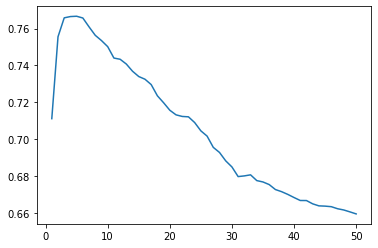

In [47]:
#Elbow method for ROC-AUC

plt.plot(data2['k-val'],data2['ROC-AUC'])

We will use the AUC_ROC metric as described before because it will best describe this dataset. We test for 50 values of K from 1 to 50 with a step size of 2 (so our K is always odd and the classifier can make a clear decision).The optimal score of AUC-ROC will sligthly chance because of the stratified cross validation, but usually the index of the best **K value will be from 5 to 7**. Running the below code will give us the maximum value from a dictionary of AUC_ROC values for K=1-50 and its corresponding index every time we run this.

In [48]:
#Find max auc-roc score

max(mean_AUC_ROC_1)


0.7666434399313761

In [49]:
#Find index of K which provided maximum AUC-ROC value for KNN classifier:

mean_AUC_ROC_1.index(max(mean_AUC_ROC_1)) + 1

5

# Question 3

Use 5-fold stratified cross-validation over training data to choose an optimal classifier
between: k-nearest neighbour, Perceptron, Naïve Bayes Classifier, Logistic regression,
Linear SVM and Kernelized SVM. Be sure to tune the hyperparameters of each classifier
type (k for k-nearest neighbour, C and kernel type and parameters for SVM and so on).
Report the cross validation results (mean and standard deviation of accuracy, AUC-ROC
and AUC-PR across fold) of your best model. You may look into grid search as well as
ways of pre-processing data. Show code to demonstrate the results. Also show the
comparison of these classifiers using a single table

**We already have the KNN performance metrics from above now we will need to implement the other 4 classifiers:
We will use the min-max scaler pre processesed training data since it provides the highest ROC-AUC score for KNN and bibliography suggests it can be an efficient pre-processing method for getting the optimal AUC-ROC results for most classifiers**

# Gaussian Naive Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB

# naive_bayes = GaussianNB()

# naive_bayes.fit(train_x, y_labels)

# y_pred_nb = naive_bayes.predict(test_x)



In [51]:
#grid search function to optimise NB


def grid_search(train_x,train_y):
    var_smooth=range(0,300)
    param_grid={'var_smoothing':var_smooth }
    nb_optimised = GaussianNB()
    grid_search = GridSearchCV(nb_optimised, param_grid, cv =skf)
    grid_search.fit(train_x, train_y)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    return(grid_search.best_params_)
    

In [52]:
#use standart scaled data as a method of pre-processing


optimised_nb=grid_search(min_max_x,y_labels)
optimised_nb['var_smoothing']

0.7063333333333334
{'var_smoothing': 36}
GaussianNB(var_smoothing=36)


36

In [53]:
def NB(xtrain,ytrain):
    

    
    accuracies_0=[]
    AUC_ROC_0=[]
    AUC_PR_0=[]
    
    optimised_nb=grid_search(xtrain,ytrain)
    
    for train_index, test_index in skf.split(xtrain,ytrain):
        train_x, test_x, train_y, test_y = xtrain[train_index], xtrain[test_index],ytrain[train_index],ytrain[test_index]
        
     
        #call module and fit model
        
        naive_bayes = GaussianNB(var_smoothing=optimised_nb['var_smoothing'])
        #fit naive bayes 
        
        naive_bayes.fit(train_x, train_y)
        
        #make prediction to calc scores
        
        y_pred_nb = naive_bayes.predict(test_x)
        
        y_scores_NB = naive_bayes.predict_proba(test_x)[0:,1] #we need the probability values as input for the curves
        
        #calculate scores
        acc = metrics.accuracy_score(test_y,y_pred_nb)
       
        accuracies_0.append(acc)
        
        roc = metrics.roc_auc_score(test_y,y_scores_NB)
        
        AUC_ROC_0.append(roc)
        
        pr = metrics.average_precision_score(test_y,y_scores_NB)
        
        AUC_PR_0.append(pr)
        
    return accuracies_0,AUC_ROC_0,AUC_PR_0



In [54]:
nb_acc, nb_roc, nb_pr = NB(min_max_x,y_labels)

0.7063333333333334
{'var_smoothing': 36}
GaussianNB(var_smoothing=36)


In [55]:
#Mean of accuracies for K-fold cross validations for Naive Bayes:

print('The mean accuracy score is:',mean(nb_acc),'The standart deviation is',round(statistics.stdev(nb_acc),3))
print('The AUC-ROC mean score is:',mean(nb_roc),'The standart deviation is',round(statistics.stdev(nb_roc),3))
print('The AUC_PR mean score is:',mean(nb_pr),'The standart deviation is',round(statistics.stdev(nb_pr),3))

The mean accuracy score is: 0.7063333333333334 The standart deviation is 0.001
The AUC-ROC mean score is: 0.5287779945056097 The standart deviation is 0.053
The AUC_PR mean score is: 0.734235290427779 The standart deviation is 0.046


#  Logistic regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
#We will use penalty and C as parameters.Both will affect the regularisation 
#of data penalty by penalising the data differently (L1,L2 aka lasso and ridge). On the other hand C will work
#like SVM margins. The larger its value the more regularisation will be applied



#grid search function to optimise NB


def grid_search_lg(train_x,train_y):
    C_param = np.logspace(-1,3,7)
    
    param_grid = [{'C': C_param,
     'penalty':['l1']},
    {'C': C_param,
     'penalty':['l2']},]
    
    lr_optimised = LogisticRegression(max_iter=10000)
    grid_search = GridSearchCV(lr_optimised, param_grid, cv = skf)
    
    grid_search.fit(train_x, train_y)
    
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    return(grid_search.best_params_)

In [58]:
optimised_lr = grid_search_lg(min_max_x, y_labels)

optimised_lr['C']

/Users/panagiotissotirellos/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/panagiotissotirellos/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/panagiotissotirellos/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/panagiotissotirellos/opt/anaconda3/lib/pytho

0.68
{'C': 0.1, 'penalty': 'l2'}
LogisticRegression(C=0.1, max_iter=10000)


0.1

In [59]:
#Function to apply logistic regression
def LogisticRegression1(xtrain,ytrain):
    
    
    
    accuracies_0=[]
    AUC_ROC_0=[]
    AUC_PR_0=[]
    
    
    for train_index, test_index in skf.split(xtrain,ytrain):
        train_x, test_x, train_y, test_y = xtrain[train_index], xtrain[test_index],ytrain[train_index],ytrain[test_index]
        
     
        #call module and fit model
        
        logistic_reg = LogisticRegression(max_iter=1000, C = optimised_lr['C'], penalty = 'l2').fit(train_x, train_y)
        
        #make prediction to calc scores
        
        y_pred_lg = logistic_reg.predict(test_x)
        
        y_scores_lg = logistic_reg.predict_proba(test_x)[0:,1]
        
        #calculate scores
        acc = metrics.accuracy_score(test_y,y_pred_lg)
       
        accuracies_0.append(acc)
        
        roc = metrics.roc_auc_score(test_y,y_scores_lg)
        
        AUC_ROC_0.append(roc)
        
        pr = metrics.average_precision_score(test_y,y_scores_lg)
        
        AUC_PR_0.append(pr)
        
    return accuracies_0,AUC_ROC_0,AUC_PR_0






In [60]:
#use standart scaled data as a method of pre-processing
LogisticRegression1(min_max_x, y_labels)

([0.665, 0.7116666666666667, 0.6866666666666666, 0.6716666666666666, 0.665],
 [0.5726307890222984,
  0.6198810034305317,
  0.5387944897084048,
  0.5735331436737856,
  0.57194374323837],
 [0.7612670897844416,
  0.7870332493721077,
  0.73647188658701,
  0.7632980515738674,
  0.7471776978852235])

In [61]:
lr_acc, lr_roc, lr_pr = LogisticRegression1(min_max_x, y_labels)

In [62]:
#Mean of accuracies for K-fold cross validations for Logistic Regression

print('The mean accuracy score is:',mean(lr_acc),'The standart deviation is',round(statistics.stdev(lr_acc),3))
print('The AUC-ROC mean score is:',mean(lr_roc),'The standart deviation is',round(statistics.stdev(lr_roc),3))
print('The AUC_PR mean score is:',mean(lr_pr),'The standart deviation is',round(statistics.stdev(lr_pr),3))

The mean accuracy score is: 0.68 The standart deviation is 0.02
The AUC-ROC mean score is: 0.575356633814678 The standart deviation is 0.029
The AUC_PR mean score is: 0.75904959504053 The standart deviation is 0.019


# Linear SVM 

In [63]:
from sklearn.svm import LinearSVC


# linsvc = LinearSVC(C=1)
# linsvc.fit(X,y)

In [64]:
#grid search function to optimise Linear SVM


def grid_search_SVM(train_x,train_y):
    C_param = np.logspace(-10,3,7)
    
    param_grid = [{'C': C_param,
     'penalty':['l1']},
    {'C': C_param,
     'penalty':['l2']},]
    
    svm_optimised = LinearSVC(max_iter=1000000)
    grid_search = GridSearchCV(svm_optimised, param_grid, cv = skf)
    
    grid_search.fit(train_x, train_y)
    
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    return(grid_search.best_params_)

In [65]:
optimised_svm_linear = grid_search_lg(min_max_x, y_labels)

optimised_svm_linear['C']

/Users/panagiotissotirellos/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/panagiotissotirellos/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/panagiotissotirellos/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/panagiotissotirellos/opt/anaconda3/lib/pytho

0.68
{'C': 0.1, 'penalty': 'l2'}
LogisticRegression(C=0.1, max_iter=10000)


0.1

In [66]:
def LinearSVM1(xtrain,ytrain):
    
    
    
    accuracies_0=[]
    AUC_ROC_0=[]
    AUC_PR_0=[]
    
    
    for train_index, test_index in skf.split(xtrain,ytrain):
        train_x, test_x, train_y, test_y = xtrain[train_index], xtrain[test_index],ytrain[train_index],ytrain[test_index]
        
     
        #call module and fit model
        
        linear_SVM = LinearSVC(max_iter=100000, C = optimised_svm_linear['C'] , penalty = 'l2').fit(train_x, train_y)
        
        #make prediction to calc scores
        
        y_pred_linear_SVM = linear_SVM.decision_function(test_x)
        
        # accuracy method:
        y_pred_SVM = linear_SVM.predict(test_x)
        
        
        #calculate scores
        acc = metrics.accuracy_score(test_y,y_pred_SVM) 
# No point in trying to use a classification   metric (accuracy) in an SVM (i.e. numeric prediction) model.
       
        accuracies_0.append(acc)
        
        roc = metrics.roc_auc_score(test_y,y_pred_linear_SVM)
        
        AUC_ROC_0.append(roc)
        
        pr = metrics.average_precision_score(test_y,y_pred_linear_SVM)
        
        AUC_PR_0.append(pr)
        
    return accuracies_0, AUC_ROC_0,AUC_PR_0




In [67]:
LinearSVM1(min_max_x, y_labels)

([0.6133333333333333, 0.6616666666666666, 0.63, 0.625, 0.63],
 [0.5478532375643225,
  0.5890196183533447,
  0.5250455617495713,
  0.548196230850396,
  0.555769256454435],
 [0.755068151824794,
  0.7647616470835594,
  0.723901215623799,
  0.7558074299343742,
  0.7327908563100516])

In [68]:
linear_SVM_acc,linear_SVM_roc, linear_SVM_pr = LinearSVM1(min_max_x, y_labels)

In [69]:
#Mean of accuracies for K-fold cross validations for Linear SVC

print('The accuracy mean score is:',mean(linear_SVM_acc),'The standart deviation is',round(statistics.stdev(linear_SVM_acc),3))
print('The AUC-ROC mean score is:',mean(linear_SVM_roc),'The standart deviation is',round(statistics.stdev(linear_SVM_roc),3))
print('The AUC_PR mean score is:',mean(linear_SVM_pr),'The standart deviation is',round(statistics.stdev(linear_SVM_pr),3))




The accuracy mean score is: 0.6316666666666666 The standart deviation is 0.018
The AUC-ROC mean score is: 0.5531767809944139 The standart deviation is 0.023
The AUC_PR mean score is: 0.7464658601553156 The standart deviation is 0.017


# Kernelised SVM

In [70]:
from sklearn.svm import SVC




In [71]:
#Grid Search: for kernelised SVM

def grid_search_kernelisedSVM(train_x,train_y):
    C_param = np.logspace(-10,3,7)
    
    param_grid = [{'C': C_param,
     'kernel':['rbf']},
    {'C': C_param,
     'kernel':['poly']},
    {'C': C_param, 
     'kernel':['sigmoid']}]
    
    kernel_optimised = SVC(max_iter=1000000)
    grid_search = GridSearchCV(kernel_optimised, param_grid, cv = skf)
    
    grid_search.fit(train_x, train_y)
    
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    return(grid_search.best_params_)


In [72]:
#this grid search takes some time to run ~3 mins
optimised_kernel = grid_search_kernelisedSVM(min_max_x, y_labels)

optimised_kernel['C']
optimised_kernel['kernel']

0.7433333333333334
{'C': 1000.0, 'kernel': 'rbf'}
SVC(C=1000.0, max_iter=1000000)


'rbf'

In [73]:
def kernelisedSVM1(xtrain,ytrain):
    
    
    
    accuracies_0=[]
    AUC_ROC_0=[]
    AUC_PR_0=[]
    
    
    for train_index, test_index in skf.split(xtrain,ytrain):
        train_x, test_x, train_y, test_y = xtrain[train_index], xtrain[test_index],ytrain[train_index],ytrain[test_index]
        
     
        #call module and fit model
        
        kernelised_SVM = SVC(max_iter=100000, C = optimised_kernel['C'], kernel= optimised_kernel['kernel']).fit(train_x, train_y)
        
        #make prediction to calc scores
        
        y_pred_kernelised_SVM = kernelised_SVM.decision_function(test_x)
        
        # accuracy method:
        y_pred_SVM = kernelised_SVM.predict(test_x)
        
        
        #calculate scores
        acc = metrics.accuracy_score(test_y,y_pred_SVM) 
# No point in trying to use a classification   metric (accuracy) in an SVM (i.e. numeric prediction) model.
       
        accuracies_0.append(acc)
        
        roc = metrics.roc_auc_score(test_y,y_pred_kernelised_SVM)
        
        AUC_ROC_0.append(roc)
        
        pr = metrics.average_precision_score(test_y,y_pred_kernelised_SVM)
        
        AUC_PR_0.append(pr)
        
    return accuracies_0, AUC_ROC_0,AUC_PR_0


In [74]:
kernel_SVM_acc,kernel_SVM_roc, kernel_SVM_pr = kernelisedSVM1(min_max_x, y_labels)

In [75]:
#Mean of accuracies for K-fold cross validations for kernelised SVC

print('The accuracy mean score is:',mean(kernel_SVM_acc),'The standart deviation is',round(statistics.stdev(kernel_SVM_acc),3))
print('The AUC-ROC mean score is:',mean(kernel_SVM_roc),'The standart deviation is',round(statistics.stdev(kernel_SVM_roc),3))
print('The AUC_PR mean score is:',mean(kernel_SVM_pr),'The standart deviation is',round(statistics.stdev(kernel_SVM_pr),3))




The accuracy mean score is: 0.7433333333333334 The standart deviation is 0.01
The AUC-ROC mean score is: 0.7653837379738548 The standart deviation is 0.018
The AUC_PR mean score is: 0.8784593313373769 The standart deviation is 0.01


# Perceptron

In [76]:
from sklearn.linear_model import Perceptron


In [77]:
#Grid Search: for Perceptron

def grid_search_perceptron(train_x,train_y):
    
    param_grid=[
    {'alpha':[1e-20,1e-19,1e-18,1e-17,1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,
                     1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10],
     'penalty':['l1']},
    {'alpha':[1e-20,1e-19,1e-18,1e-17,1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,
                     1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10],
     'penalty':['l2']},
]

    
    perceptron_optimised = Perceptron()
    grid_search = GridSearchCV(perceptron_optimised, param_grid, cv = skf)
    
    grid_search.fit(train_x, train_y)
    
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    return(grid_search.best_params_)

In [78]:
#perceptron grid search optimisation to put back in the defined perceptron function
optimised_perceptron = grid_search_perceptron(min_max_x, y_labels)

optimised_perceptron['alpha']
optimised_perceptron['penalty']

0.6846666666666666
{'alpha': 0.001, 'penalty': 'l1'}
Perceptron(alpha=0.001, penalty='l1')


'l1'

In [79]:
def perceptron(xtrain,ytrain):
    
    
    
    accuracies_0=[]
    AUC_ROC_0=[]
    AUC_PR_0=[]
    
    
    for train_index, test_index in skf.split(xtrain,ytrain):
        train_x, test_x, train_y, test_y = xtrain[train_index], xtrain[test_index],ytrain[train_index],ytrain[test_index]
        
     
        #call module and fit model
        
        perceptron = Perceptron(max_iter=100000, alpha = optimised_perceptron['alpha'], penalty= optimised_perceptron['penalty'] ).fit(train_x, train_y)
        
        #make prediction to calc scores
        
        y_pred_perceptron = perceptron.decision_function(test_x)
        
        # accuracy method:
        y_pred_perc = perceptron.predict(test_x)
        
        
        #calculate scores
        acc = metrics.accuracy_score(test_y,y_pred_perc) 
# No point in trying to use a classification   metric (accuracy) in an SVM (i.e. numeric prediction) model.
       
        accuracies_0.append(acc)
        
        roc = metrics.roc_auc_score(test_y,y_pred_perceptron)
        
        AUC_ROC_0.append(roc)
        
        pr = metrics.average_precision_score(test_y,y_pred_perceptron)
        
        AUC_PR_0.append(pr)
        
    return accuracies_0, AUC_ROC_0,AUC_PR_0


In [80]:
perceptron(min_max_x, y_labels)

([0.7, 0.71, 0.655, 0.6566666666666666, 0.7016666666666667],
 [0.5572335977701544,
  0.5752974914236706,
  0.5238663164665524,
  0.5052824190941753,
  0.5469941632941994],
 [0.7411218616039427,
  0.758462210105039,
  0.7321794122539069,
  0.7067319518206518,
  0.7404907635069691])

In [81]:
perceptron_acc,perceptron_roc, perceptron_pr = perceptron(min_max_x, y_labels)

In [82]:
#Mean of accuracies for K-fold cross validations for Perceptron

print('The accuracy mean score is:',mean(perceptron_acc),'The standart deviation is',round(statistics.stdev(perceptron_acc),3))
print('The AUC-ROC mean score is:',mean(perceptron_roc),'The standart deviation is',round(statistics.stdev(perceptron_roc),3))
print('The AUC_PR mean score is:',mean(perceptron_pr),'The standart deviation is',round(statistics.stdev(perceptron_pr),3))




The accuracy mean score is: 0.6846666666666666 The standart deviation is 0.027
The AUC-ROC mean score is: 0.5417347976097504 The standart deviation is 0.028
The AUC_PR mean score is: 0.7357972398581019 The standart deviation is 0.019


# Table

In [83]:
classifiers = ['knn','Naive bayes','logistic','linear svm','kernelised svm','perceptron']

In [84]:
classifier_acc = [mean(acc), mean(nb_acc), mean(lr_acc), mean(linear_SVM_acc), mean(kernel_SVM_acc), mean(perceptron_acc)]

classifier_auc = [mean(roc), mean(nb_roc), mean(lr_roc), mean(linear_SVM_roc), mean(kernel_SVM_roc), mean(perceptron_roc)]

classifier_pr = [mean(pr), mean(nb_pr), mean(lr_pr), mean(linear_SVM_pr),mean(kernel_SVM_pr), mean(perceptron_pr)]

acc_std = [statistics.stdev(acc), statistics.stdev(nb_acc), statistics.stdev(lr_acc), 
          statistics.stdev(linear_SVM_acc), statistics.stdev(kernel_SVM_acc), statistics.stdev(perceptron_acc) ]

roc_std = [statistics.stdev(roc), statistics.stdev(nb_roc), statistics.stdev(lr_roc), 
          statistics.stdev(linear_SVM_roc), statistics.stdev(kernel_SVM_roc), statistics.stdev(perceptron_roc)]

pr_std = [statistics.stdev(pr), statistics.stdev(nb_pr), statistics.stdev(lr_pr), 
          statistics.stdev(linear_SVM_pr), statistics.stdev(kernel_SVM_pr), statistics.stdev(perceptron_pr)]






In [85]:
df1= pd.DataFrame({'Classifier' : classifiers ,'Accuracy': classifier_acc, ' Accuracy Std' : acc_std , 'AUC-ROC' : classifier_auc ,
                 'AUC-ROC Std' : roc_std, 'AUC_PR' : classifier_pr, 'PR-Std' : pr_std  })




In [86]:
df1.set_index('Classifier', inplace=True)


In [87]:
df1

,Accuracy,Accuracy Std,AUC-ROC,AUC-ROC Std,AUC_PR,PR-Std
Classifier,,,,,,
knn,0.738750,0.010582,0.762023,0.021310,0.845371,0.016977
Naive bayes,0.706333,0.001394,0.528778,0.052803,0.734235,0.046245
logistic,0.680000,0.019791,0.575357,0.028903,0.759050,0.019084
linear svm,0.631667,0.018105,0.553177,0.023108,0.746466,0.017264
kernelised svm,0.743333,0.010000,0.765384,0.018331,0.878459,0.009521
perceptron,0.684667,0.026599,0.541735,0.027579,0.735797,0.018854


We can see that **knn with k=5** and the **kernelised SVM with kernel = "rbf"** and C=0.01 yield the best AUC-ROC metric.

As stated earlier we want to look at this metric because of the imbalance of the classes leaning towards the positive one. If the majority of examples was of negative class we could have used precision (auc-pr) as a metric which is more sensitive to positive class distribution due to its components (TPR and positive predicted value).However in this case if we choose to go with this metric it will be perilous, same with accuracy since the classes are not balanced.

# Question 4 

**i)** Reduce the number of dimensions of the data using PCA to 2 and plot a scatter plot of
the training data. What are your observations about the data based on data?

In [88]:
from sklearn.decomposition import PCA



In [89]:
# pca = PCA()
# df_pca = pd.DataFrame(pca.fit_transform(df_scaled))
# df_pca

In [90]:
#we need to apply PCA to reduce our pre processed training data to 2 dimensions:

pca = PCA(n_components = 2)
df_pca = pd.DataFrame(pca.fit_transform(min_max_x))




In [91]:
df_pca

,0,1
0,-4.163804,-1.032376
1,5.129984,-2.373125
2,0.363063,5.516622
3,-2.140339,1.859333
4,0.469164,2.631340
...,...,...
2995,5.708602,2.118689
2996,-4.165218,-0.382898
2997,-2.514594,3.024500
2998,-2.797423,2.230404


In [92]:
import matplotlib.pyplot as plt


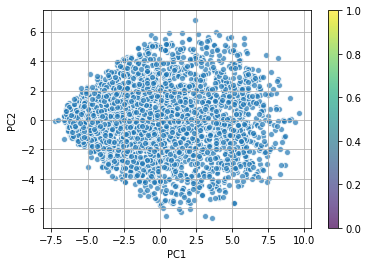

In [93]:
#project minmax scaled data on principal components

proj = pca.transform(min_max_x)

v1 = 0 #principal 1
v2 = 1 #principal 2

plt.scatter(proj[ :, v1], proj[ :, v2],
           edgecolor='white', alpha=0.7,
           cmap=plt.cm.get_cmap('Pastel2_r', 1));

plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar();
plt.show()

After we have reduced the min-max scaled training data down to 2 components it can bee understood from the graph that some points (darker blue) are more likely to be classified than the lighter blue counterparts, however it is very difficult to construct a successful classifier for this specifric distribution since the data mainly looks inseperable

**ii)** Plot the scree graph of PCA and find the number of dimensions that explain 95%
variance in the training set.

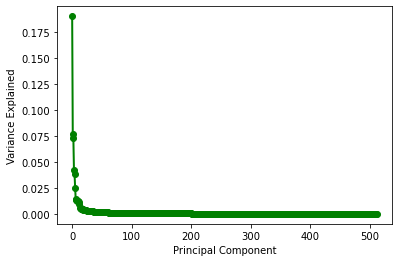

In [94]:
#one representation of the scree graph

pca1 = PCA(0.95) #we do pca again to account for all componenys 
pca1.fit_transform(min_max_x)

pca_95_var = np.arange(pca1.n_components_) 
plt.plot(pca_95_var, pca1.explained_variance_ratio_, 'o-', linewidth=2, color='green')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

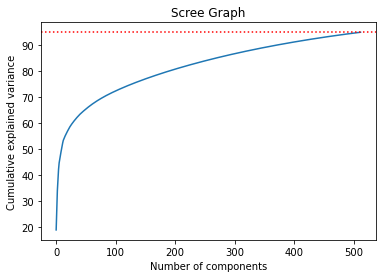

In [95]:
#Plot Scree Graph: do a cummulative summation of the graph above to vonfirm it was correct!


plt.figure()

plt.plot(np.cumsum(pca1.explained_variance_ratio_)*100) # scree graph
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Scree Graph')

#draw line

plt.axhline(y = 95, color = 'r', linestyle = 'dotted')

In [96]:
pca1.n_components_

512

We can observe that **512 components** explain 95% of the variance in the minmax scaled training dataset

**iii)** Reduce the number of dimensions of the data using PCA and perform classification.
What is the (optimal) cross-validation performance of a Kernelized SVM classification
with PCA? Remember to perform hyperparameter optimization!

In [97]:
pca_reduced = PCA(n_components = 512)

x_reduced_pca = pca_reduced.fit_transform(min_max_x)

In [98]:
#Grid Search: for kernelised SVM for reduced dimensions

def grid_search_kernelisedSVM_pca(train_x,train_y):
    C_param = np.logspace(-10,3,7)
    
    param_grid = [{'C': C_param,
     'kernel':['rbf']},
    {'C': C_param,
     'kernel':['poly']},
    {'C': C_param, 
     'kernel':['sigmoid']}]
    
    kernel_optimised = SVC(max_iter=1000000)
    grid_search = GridSearchCV(kernel_optimised, param_grid, cv = skf)
    
    grid_search.fit(train_x, train_y)
    
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    return(grid_search.best_params_)


In [99]:
#this grid search takes some time to run ~3 mins
optimised_kernel = grid_search_kernelisedSVM_pca(x_reduced_pca, y_labels)

optimised_kernel['C']
optimised_kernel['kernel']

0.7700000000000001
{'C': 6.8129206905795945, 'kernel': 'poly'}
SVC(C=6.8129206905795945, kernel='poly', max_iter=1000000)


'poly'

In [100]:
def kernelisedSVM1_pca(xtrain,ytrain):
    
    
    
    accuracies_0=[]
    AUC_ROC_0=[]
    AUC_PR_0=[]
    
    
    for train_index, test_index in skf.split(xtrain,ytrain):
        train_x, test_x, train_y, test_y = xtrain[train_index], xtrain[test_index],ytrain[train_index],ytrain[test_index]
        
     
        #call module and fit model
        
        kernelised_SVM = SVC(max_iter=100000, C = optimised_kernel['C'], kernel= optimised_kernel['kernel']).fit(train_x, train_y)
        
        #make prediction to calc scores
        
        y_pred_kernelised_SVM = kernelised_SVM.decision_function(test_x)
        
        # accuracy method:
        y_pred_SVM = kernelised_SVM.predict(test_x)
        
        
        #calculate scores
        acc = metrics.accuracy_score(test_y,y_pred_SVM) 

       
        accuracies_0.append(acc)
        
        roc = metrics.roc_auc_score(test_y,y_pred_kernelised_SVM)
        
        AUC_ROC_0.append(roc)
        
        pr = metrics.average_precision_score(test_y,y_pred_kernelised_SVM)
        
        AUC_PR_0.append(pr)
        
    return accuracies_0, AUC_ROC_0,AUC_PR_0


In [101]:
kernelisedSVM1_pca(x_reduced_pca, y_labels)

([0.7483333333333333,
  0.795,
  0.7616666666666667,
  0.7766666666666666,
  0.7683333333333333],
 [0.7552128001715266,
  0.8149120926243568,
  0.780861385077187,
  0.7983598456011005,
  0.8061599284101988],
 [0.8737024551081363,
  0.8984277121094875,
  0.8906971248669482,
  0.8729895712723157,
  0.8956084768359742])

In [102]:
reduced_pca_acc,reduced_pca_roc, reduced_pca_pr = kernelisedSVM1_pca(x_reduced_pca, y_labels)

In [103]:
#Mean of accuracies for K-fold cross validations for Perceptron

print('The accuracy mean score is:',mean(reduced_pca_acc),'The standart deviation is',round(statistics.stdev(reduced_pca_acc),3))
print('The AUC-ROC mean score is:',mean(reduced_pca_roc),'The standart deviation is',round(statistics.stdev(reduced_pca_roc),3))
print('The AUC_PR mean score is:',mean(reduced_pca_pr),'The standart deviation is',round(statistics.stdev(reduced_pca_pr),3))




The accuracy mean score is: 0.7700000000000001 The standart deviation is 0.017
The AUC-ROC mean score is: 0.7911012103768739 The standart deviation is 0.024
The AUC_PR mean score is: 0.8862850680385723 The standart deviation is 0.012


Using the kernelised svm function and grid search optimisation we created for 3, we now apply them to the components that explain 95% of variance (510). The hyperparameter optimisation gives us an optimal **C value of 6.8** and **kernel 'poly'**. The values of AUC-ROC we get when we apply PCA to the training pre processed data,are actually a tad higher than before PCA was applied (.79) compared to (.76)

# Question 5

Pipelines are very convenient in order write a clean code for all the preprocessing and models we have created. 
in this case we have established that min-max scaler is the best pre-processing technique in getting better AUC-ROC scores. for this reason we will first pass the min max scaler method on the pipeline. Following this we will also pass the two best performing classifiers in terms of auc-roc which are **1) KNN 2) Kernelised SVM** but this will be done on the reduced components of them that explain 95% of variance (512). **2 different prediction score files are generated for the reduced dimensions of the 2 models in this pipeline**

In [104]:
#pipelines are very convenient in order write a clean code for all the preprocessing and models we have created. 
#in this case we have established that min-max scaler is the best pre-processing technique in getting better AUC-ROC
#scores. for this reason we will first pass the min max scaler method on the pipeline. Following this we will also
#pass the 

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
#Pipeline structure : 1)pre-processing (min-max scaler) and knn 2) reduce dimensions with PCA and apply knn again
# 3) apply kernelised svm on reduced dimensions too



In [140]:
#implement min max scaler (pre-processing) and pass training data to knn-classifier 


pipeline = Pipeline([('minmax_scaler',min_max_scaler),('pca',PCA(n_components=512)),('knn',KNeighborsClassifier(n_neighbors=5))])

pipeline.fit(x_train,y_labels)

test_predict_0 = np.around(pipeline.predict_proba(x_test), 3)

predictions_dataframe_knn = pd.DataFrame(test_predict)

predictions_dataframe.to_csv("u2084078_1.csv", index = False)






In [139]:
#Finally after the data is pre processed and reduced also pass them to kernelised knn which was also a good classifier


pipeline = Pipeline([('minmax_scaler',min_max_scaler),('pca',PCA(n_components= 512)),('kernelised',SVC(max_iter=100000, C = optimised_kernel['C'], kernel= optimised_kernel['kernel']))] )

pipeline.fit(x_train,y_labels)

test_predict = np.around(pipeline.decision_function(x_test), 3)

predictions_dataframe_kernelised = pd.DataFrame(test_predict)

predictions_dataframe_kernelised.to_csv("u2084078_2.csv", index = False)







# I have generated 2 prediction files since kernelised svm and knn had very similar results so you can check file 1 and 2 the classifiers predict identical results

please enjoy as much as i did this cw :=)